In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import string

In [3]:
import matplotlib as mpl

FONT_SIZE = 16
AXES_SIZE = FONT_SIZE * 1.5
TICK_SIZE = FONT_SIZE * 1.25
LEGEND_SIZE = FONT_SIZE

my_rcParams = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 5,
    "font.size": FONT_SIZE,
    "font.family": "Helvetica",
    "axes.titlesize": AXES_SIZE,
    "axes.labelsize": AXES_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "xtick.major.pad": FONT_SIZE / 2,
    "ytick.major.pad": FONT_SIZE / 2,
}

for k, v in my_rcParams.items():
    mpl.rcParams[k] = v

In [4]:
errors = pd.read_csv("../errors/real_time_nextclade/model_scores.tsv", sep="\t")
pivot_dates = np.sort(errors.pivot_date.unique())

In [5]:
errors

location  model  pivot_date  lead      variant       MAE      RMSE  \
0           USA    MLR  2022-09-15   -73        Delta  0.000015  0.000015   
1           USA    MLR  2022-09-15   -72        Delta  0.000016  0.000016   
2           USA    MLR  2022-09-15   -71        Delta  0.000017  0.000017   
3           USA    MLR  2022-09-15   -70        Delta  0.000018  0.000018   
4           USA    MLR  2022-09-15   -69        Delta  0.000019  0.000019   
...         ...    ...         ...   ...          ...       ...       ...   
210439  Vietnam  naive  2022-11-01   -43  Omicron 22B  0.119156  0.119156   
210440  Vietnam  naive  2022-11-01   -42  Omicron 22B  0.114547  0.114547   
210441  Vietnam  naive  2022-11-01   -41  Omicron 22B  0.133595  0.133595   
210442  Vietnam  naive  2022-11-01   -40  Omicron 22B  0.205024  0.205024   
210443  Vietnam  naive  2022-11-01   -39  Omicron 22B  0.231418  0.231418   

          loglik  coverage  total_seq  raw_freq  smoothed_freq  pred_freq  \
0      -0.058088       1.0     2579.0  0.000000       0.000038   0.000023   
1      -0.228218       1.0    10624.0  0.000000       0.000038   0.000021   
2      -1.965704       1.0     8078.0  0.000124       0.000038   0.000020   
3      -2.114733       1.0     7102.0  0.000141       0.000038   0.000020   
4      -0.127575       1.0     6895.0  0.000000       0.000038   0.000019   
...          ...       ...        ...       ...            ...        ...   
210439      -inf       NaN       21.0  0.904762       0.880844   1.000000   
210440      -inf       NaN       26.0  0.807692       0.885453   1.000000   
210441      -inf       NaN       42.0  0.857143       0.866405   1.000000   
210442      -inf       NaN       35.0  0.828571       0.794976   1.000000   
210443  0.000000       NaN       14.0  1.000000       0.768582   1.000000   

              date    ci_low   ci_high nextclade_version  
0       2022-07-04  0.000011  0.000045     retrospective  
1       2022-07-05  0.000011  0.000043     retrospective  
2       2022-07-06  0.000010  0.000043     retrospective  
3       2022-07-07  0.000010  0.000042     retrospective  
4       2022-07-08  0.000009  0.000041     retrospective  
...            ...       ...       ...               ...  
210439  2022-09-19       NaN       NaN         real_time  
210440  2022-09-20       NaN       NaN         real_time  
210441  2022-09-21       NaN       NaN         real_time  
210442  2022-09-22       NaN       NaN         real_time  
210443  2022-09-23       NaN       NaN         real_time  

[210444 rows x 17 columns]

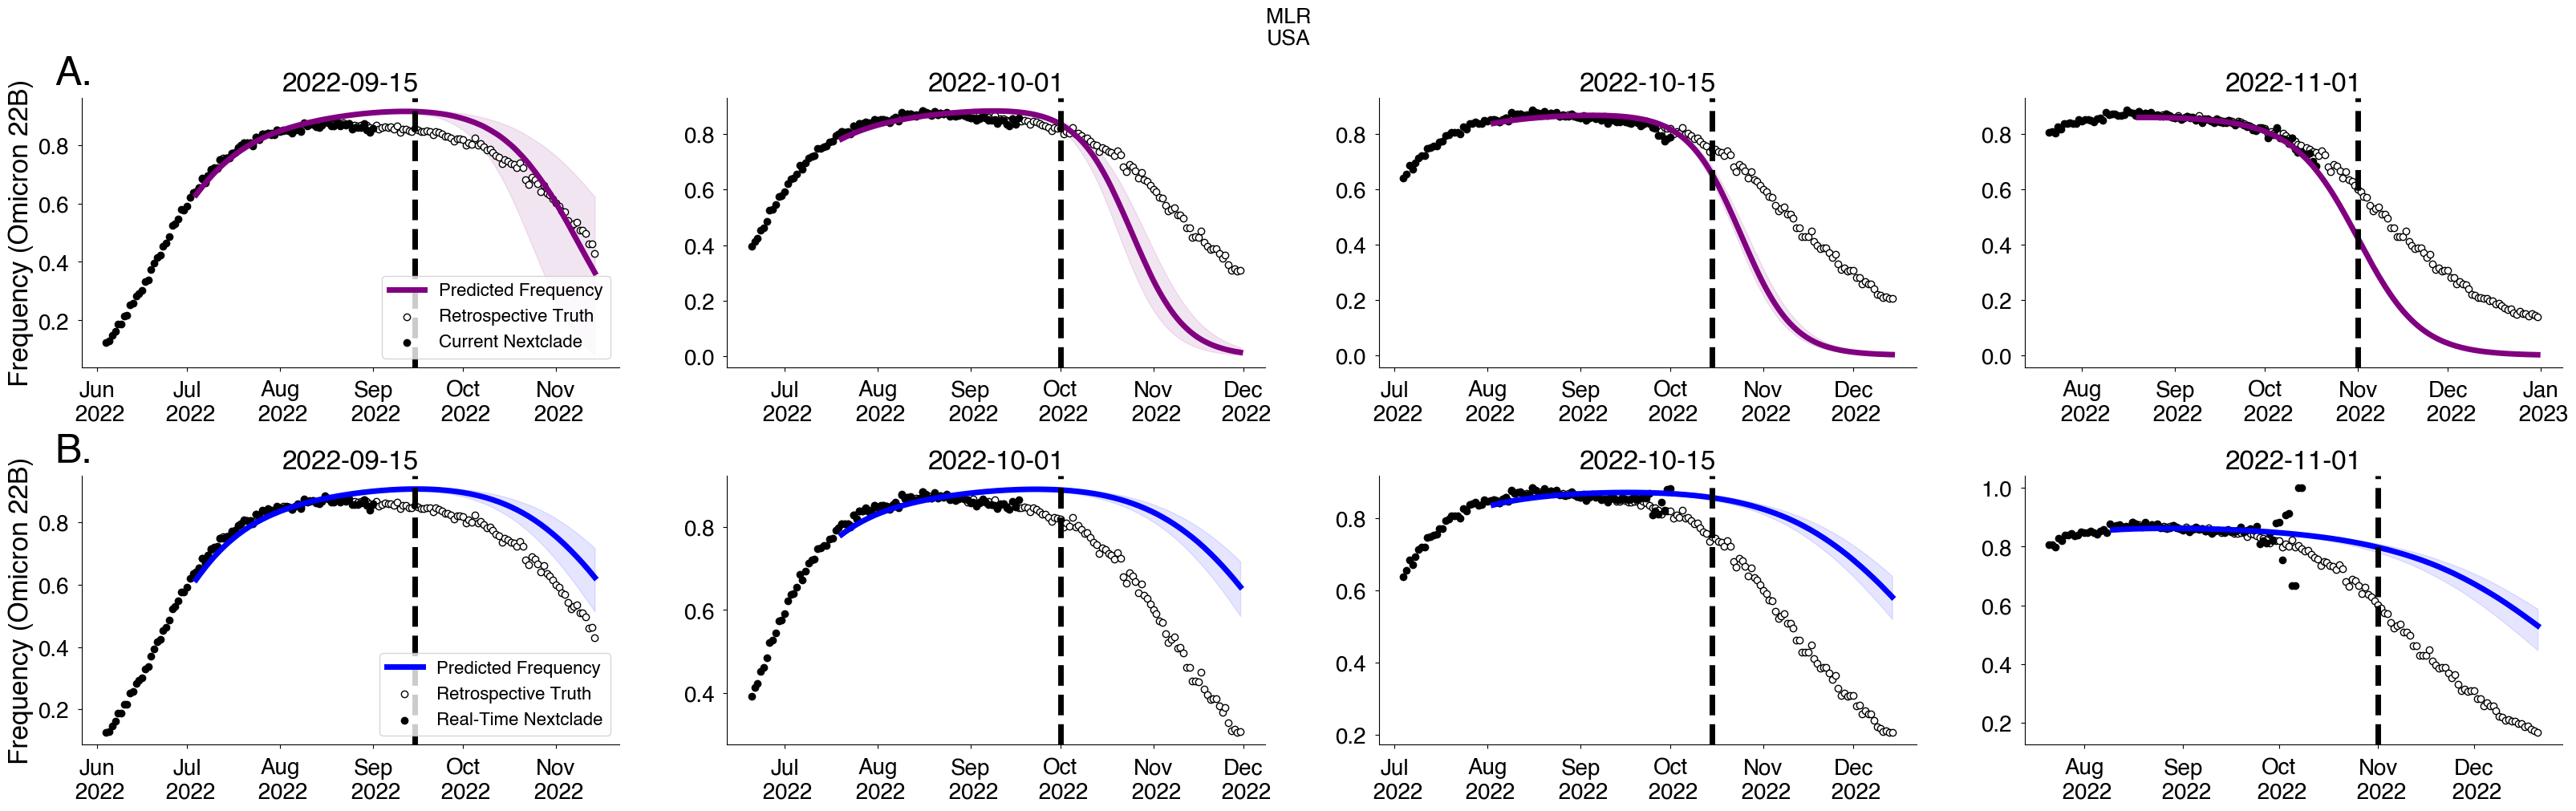

In [26]:
import matplotlib.dates as mdates

NC_VERSION_TO_DATASET = {"retrospective": "", "real_time": "_past"}
NC_VERSION_TO_LABEL = {"retrospective": "Current Nextclade", "real_time": "Real-Time Nextclade"}


def prep_training_data(pivot, location, variant, nextclade_version):
    dataset = NC_VERSION_TO_DATASET[nextclade_version]
    this_data = pd.read_csv(f"../data/real_time_nextclade/{pivot}/seq_counts_{pivot}{dataset}.tsv", sep="\t")
    this_data = this_data[this_data["location"] == location]
    total_sequences = this_data.groupby(["date", "location"])["sequences"].sum()
    total_sequences.name = "total_sequences"
    this_data = this_data[this_data["variant"] == variant]
    this_data = this_data.merge(total_sequences, on=["date", "location"])
    return this_data

location = "USA"
variant = "Omicron 22B"
model = "MLR"

COLOR = ["purple", "blue"]

def make_nextclade_comparison_plot(variant, location, model):
    fig = plt.figure(figsize=(32., 10.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=4, nrows=2, wspace=0.1)

    axes_to_label = []
    for n, nextclade_version in enumerate(["retrospective", "real_time"]):
        for p, pivot in enumerate(pivot_dates):
            ax = fig.add_subplot(spec[n, p])
            _errors = errors[errors["model"] == model]
            _error = _errors[_errors["pivot_date"] == pivot]
            _error = _error[_error["variant"] == variant]
            _error = _error[_error["location"] == location]
            _error = _error[_error["nextclade_version"] == nextclade_version]

            this_data = prep_training_data(pivot, location, variant, nextclade_version)

            # Plot prediction
            ax.plot(pd.to_datetime(_error.date), _error.pred_freq, color=COLOR[n], label="Predicted Frequency")
            ax.fill_between(pd.to_datetime(_error.date), _error.ci_low, _error.ci_high, color=COLOR[n], alpha=0.1)

            # Plot retrospective data
            ax.scatter(pd.to_datetime(_error.date), _error.raw_freq, color="w", ec='k', label="Retrospective Truth")

            # Plot oberved frequency
            ax.scatter(pd.to_datetime(this_data.date), 
                       this_data["sequences"] / this_data["total_sequences"], 
                       color="k", 
                       ec='k', 
                       label=NC_VERSION_TO_LABEL[nextclade_version])

            # Pivot date
            ax.axvline(x=pd.to_datetime(pivot), color="k", linestyle="--")
            ax.set_title(pivot)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n %Y'))
            if p == 0:
                ax.set_ylabel(f"Frequency ({variant})")
                ax.legend()
                axes_to_label.append(ax)
                
    ax_labels = [s + "." for s in string.ascii_uppercase]
    for ax, ax_label in zip(axes_to_label, ax_labels):
        ax.text(-0.05, 1.05, ax_label, transform=ax.transAxes, size=36, weight='bold')
    
    fig.suptitle(model + "\n" + location)
    return fig

fig = make_nextclade_comparison_plot(variant, location, model)

# TODO: Add 22B and 22E to same plots (will be empty for B)
# TODO: Analysis dates -> 2022-09-15 -- 2022-10-12

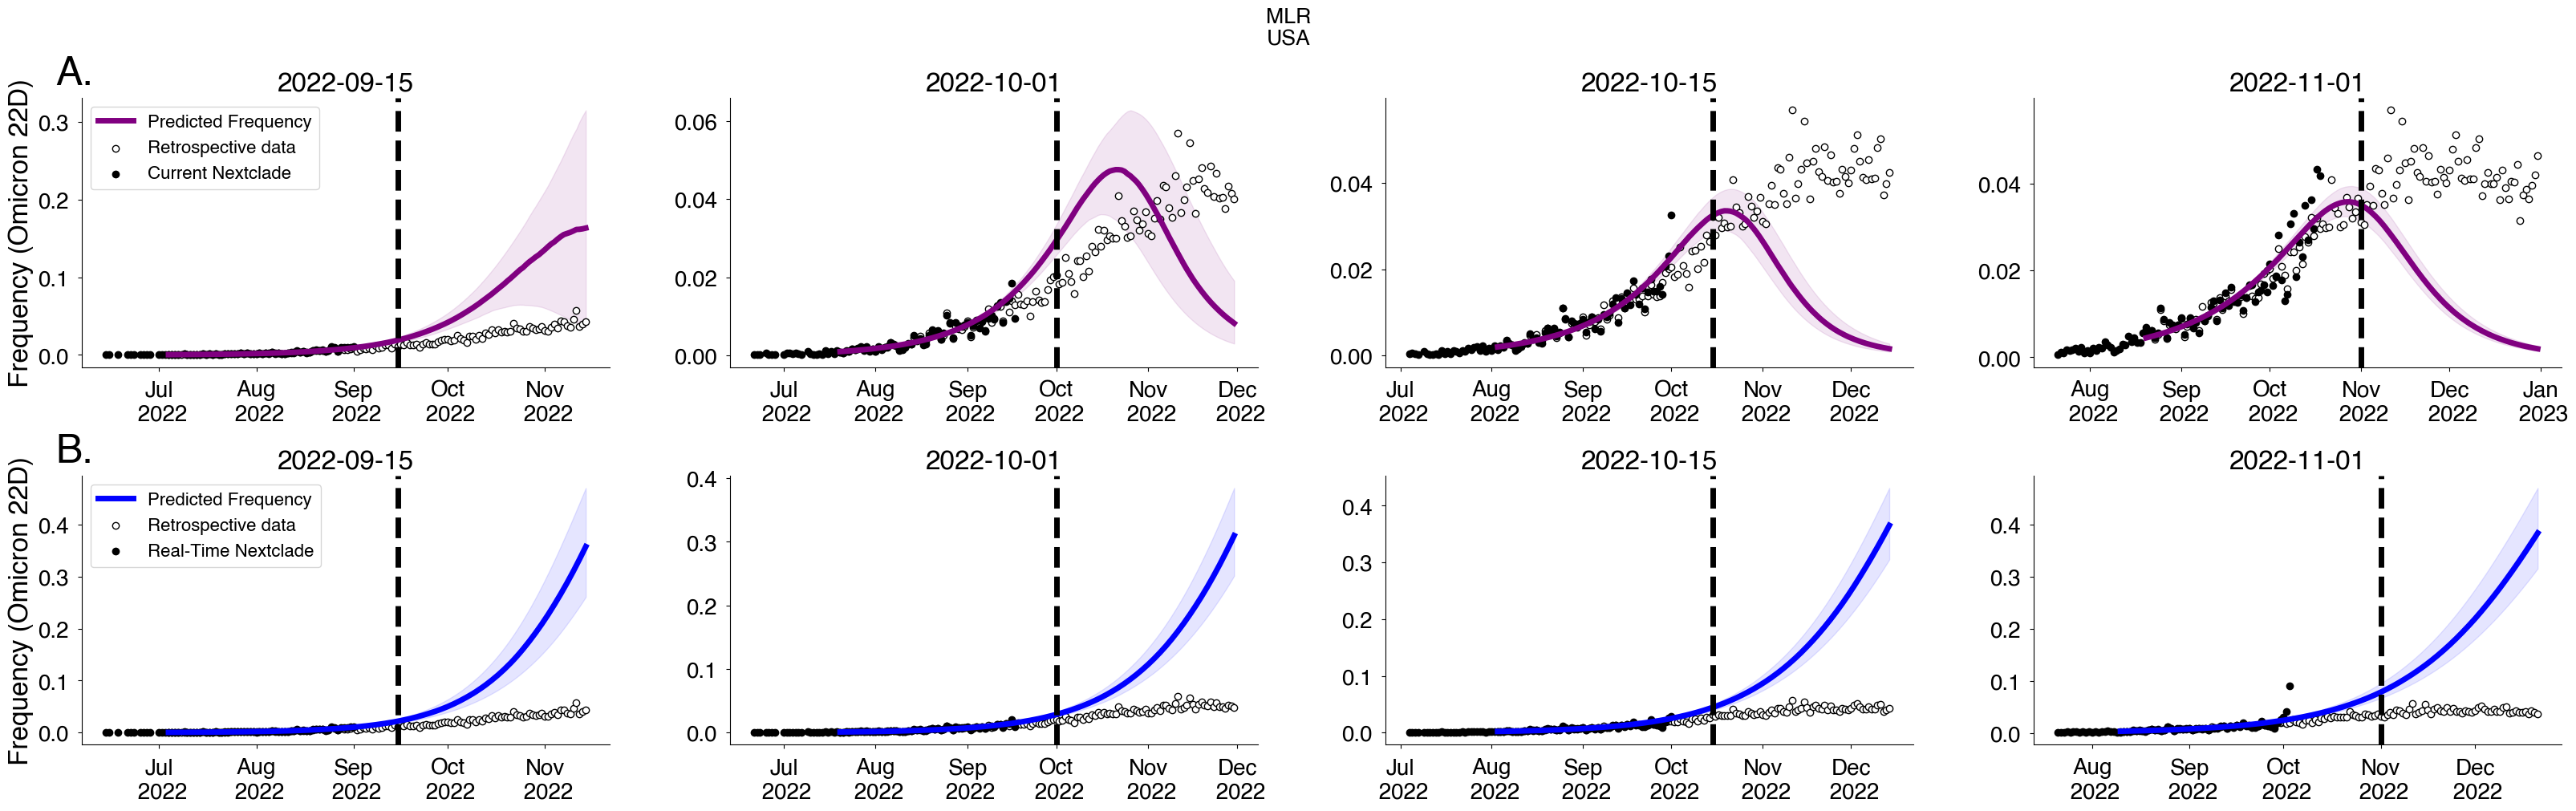

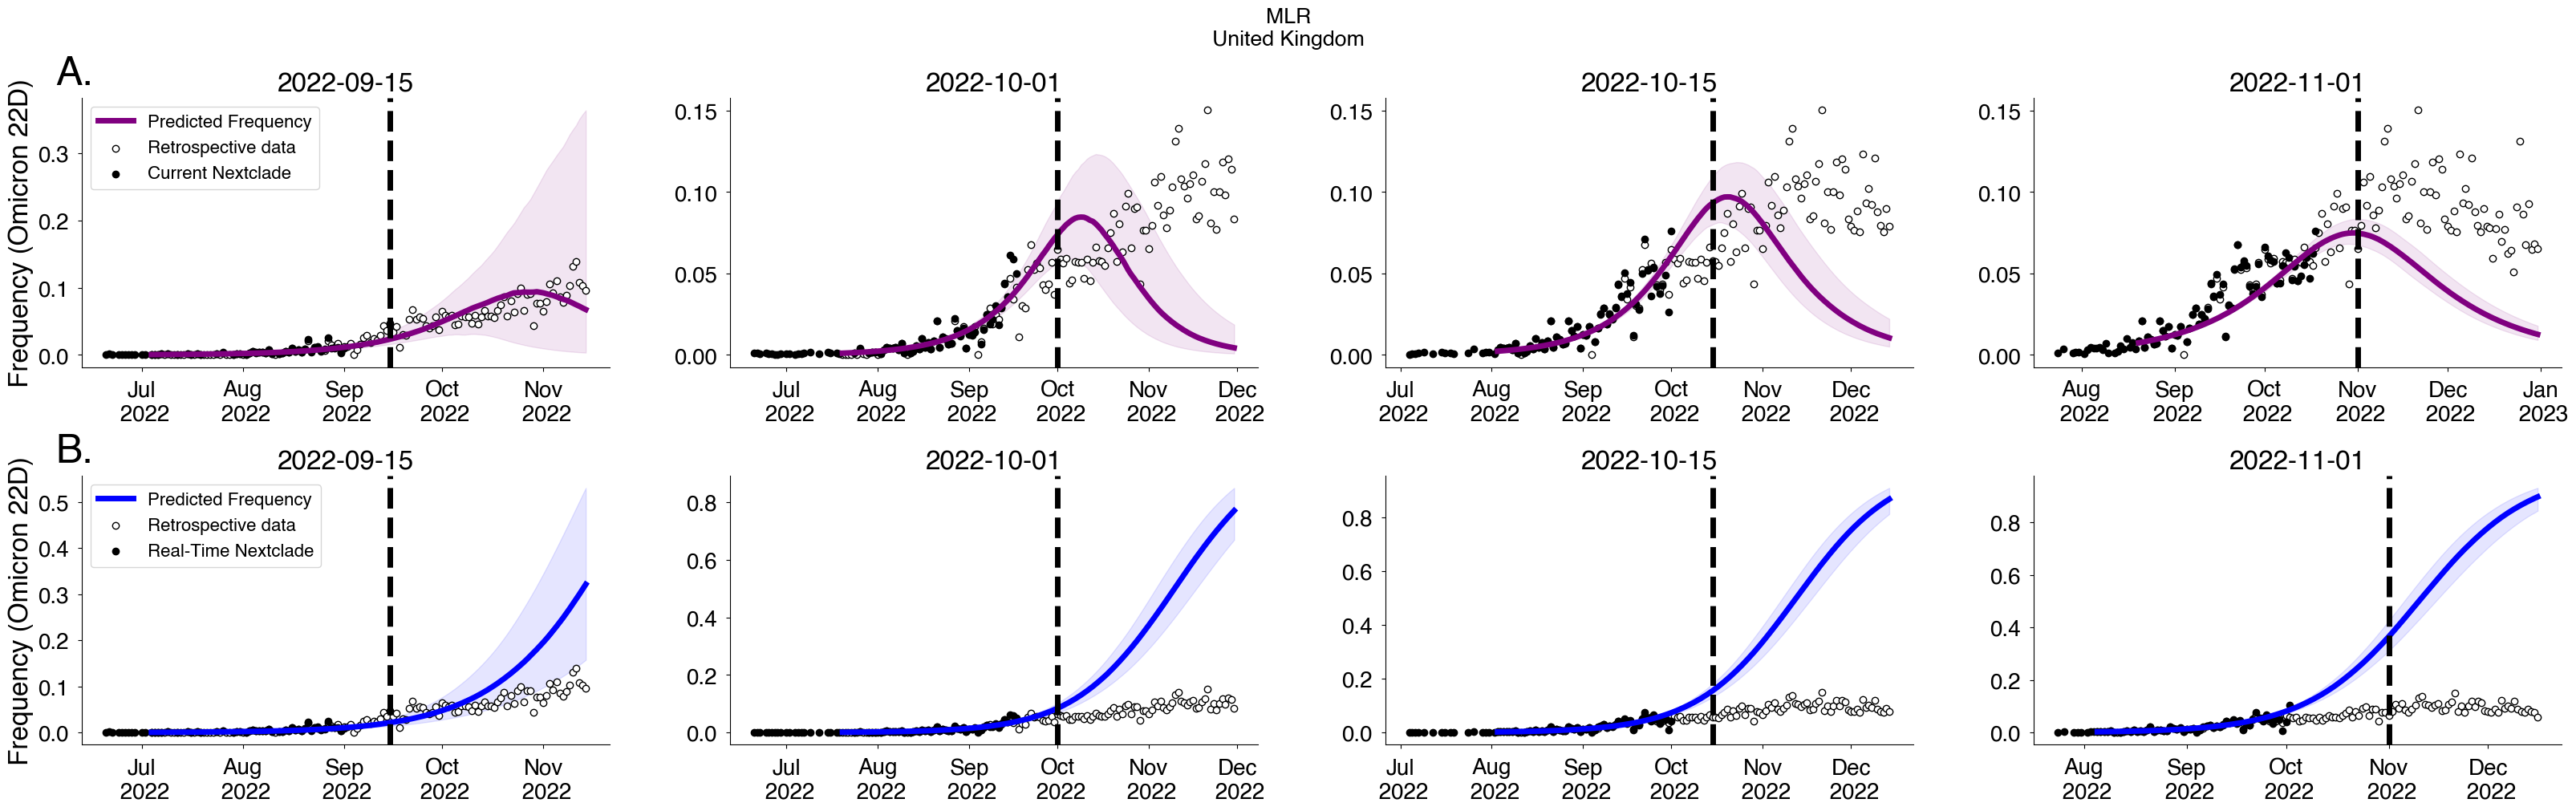

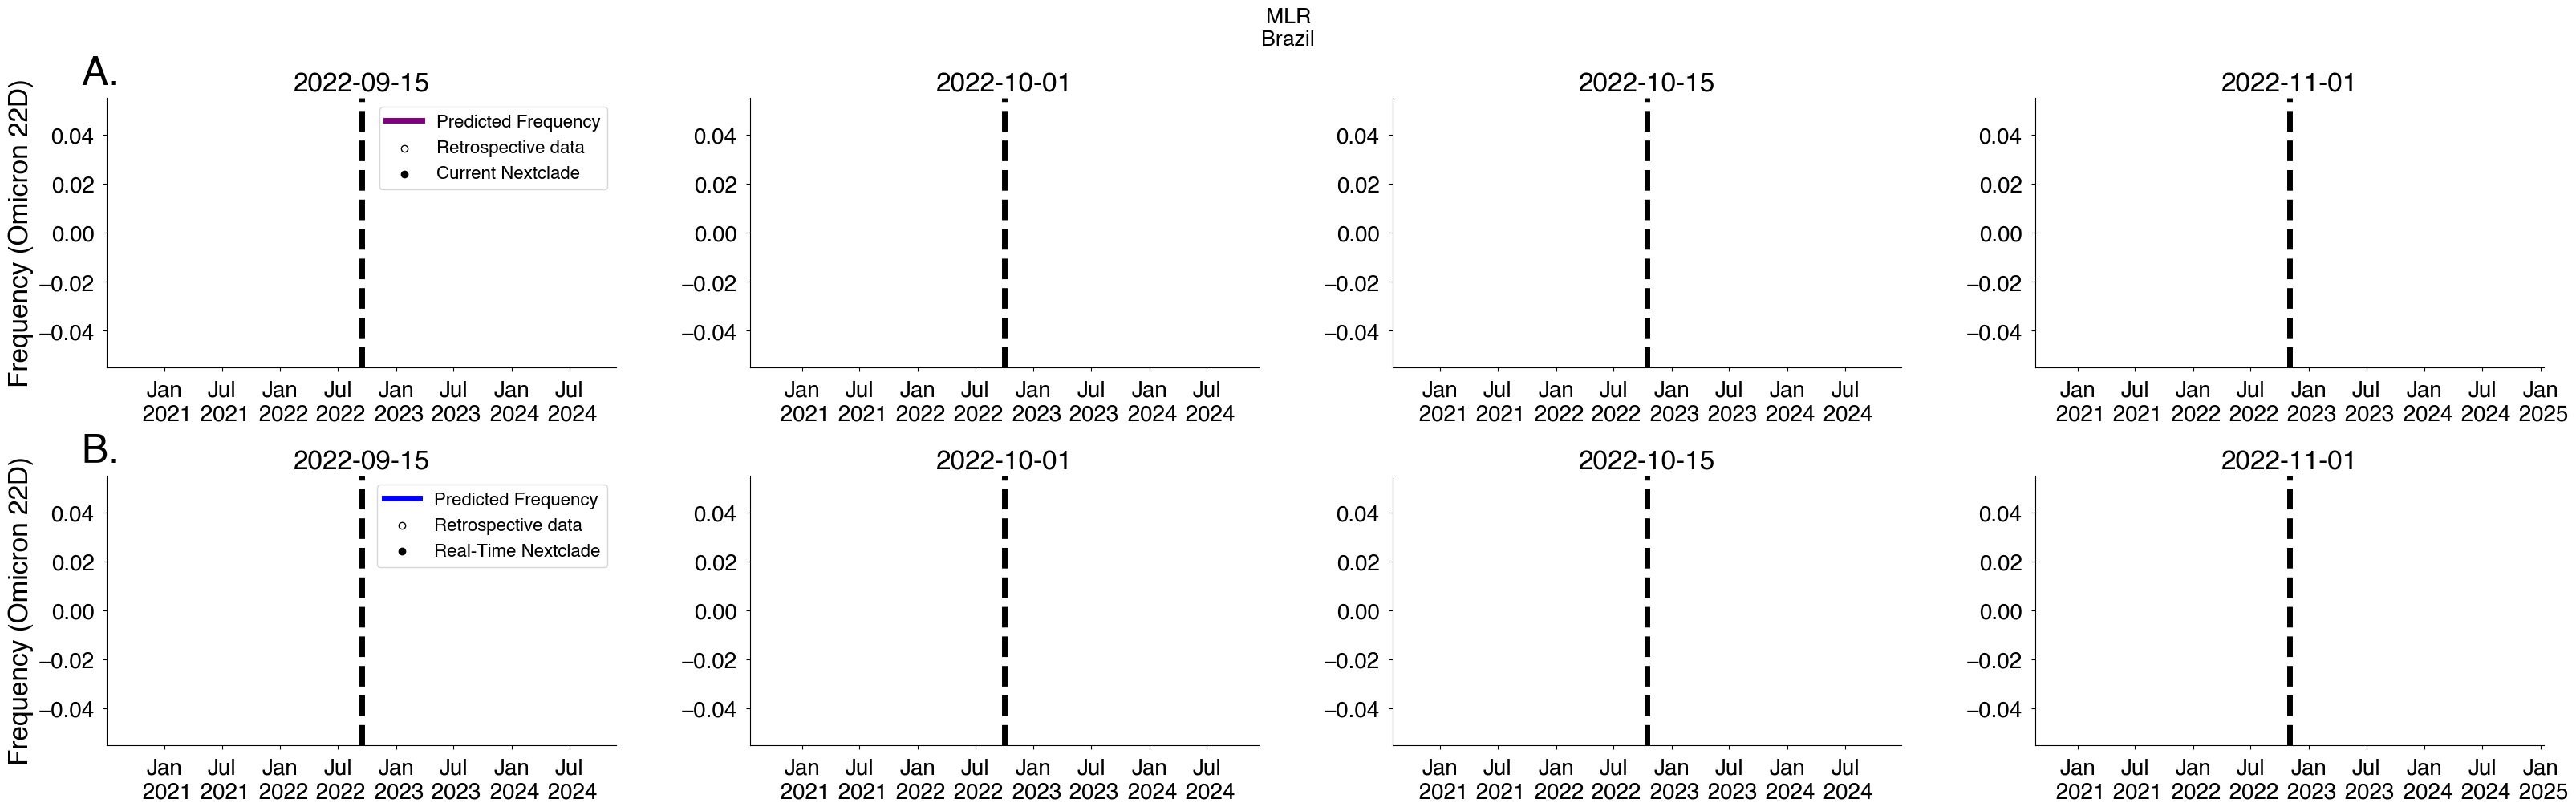

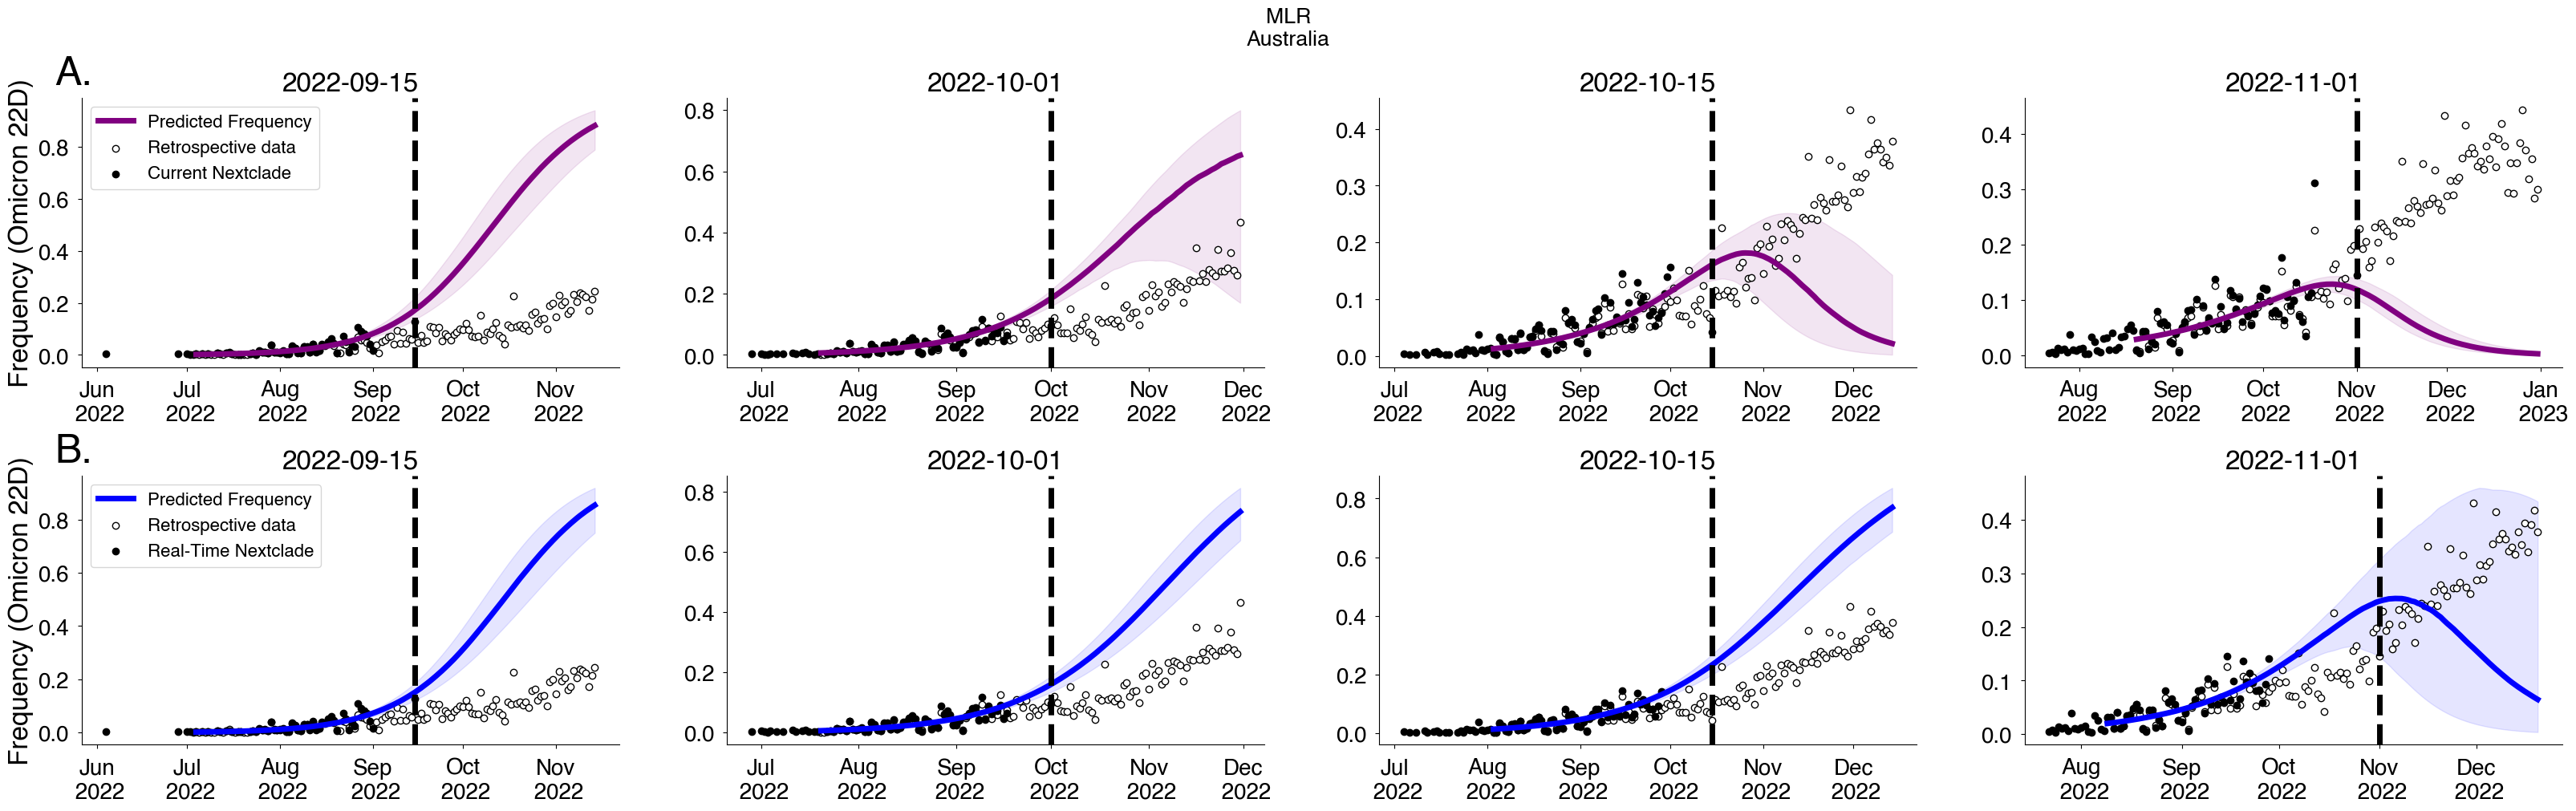

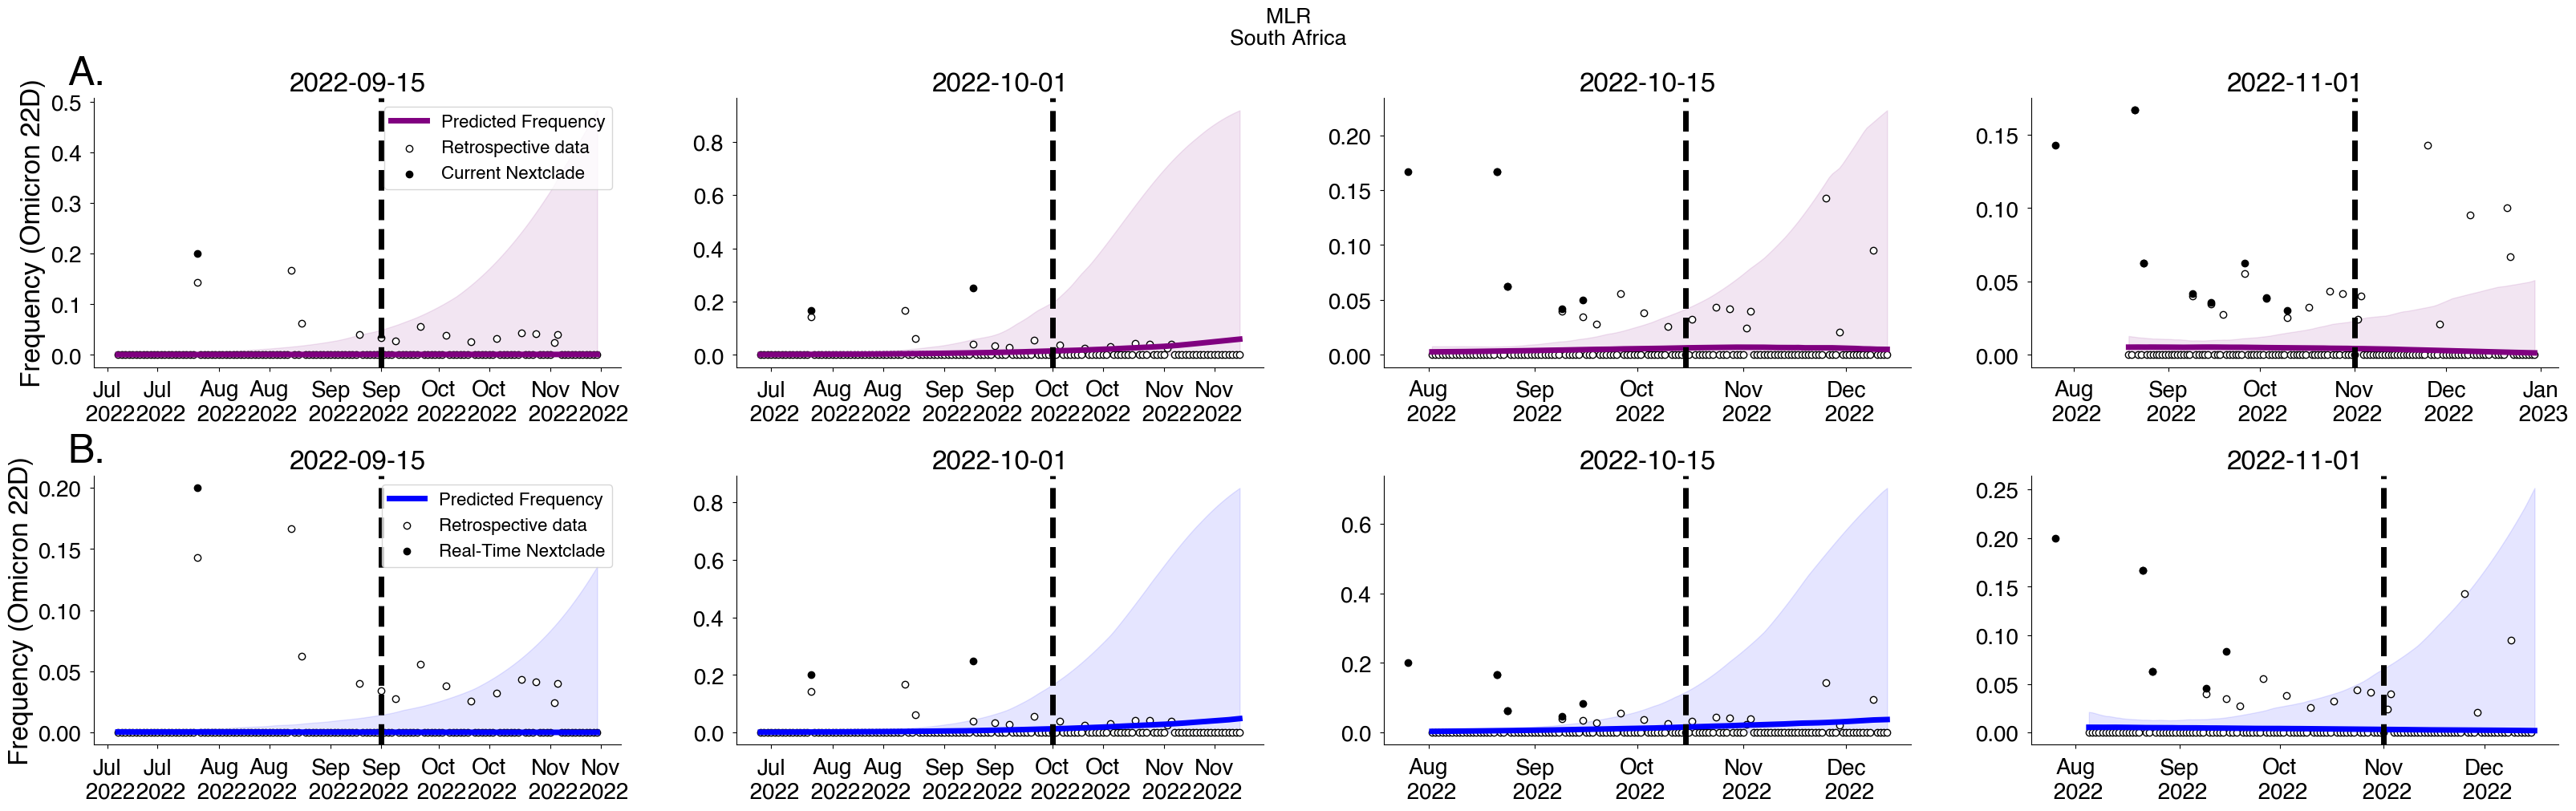

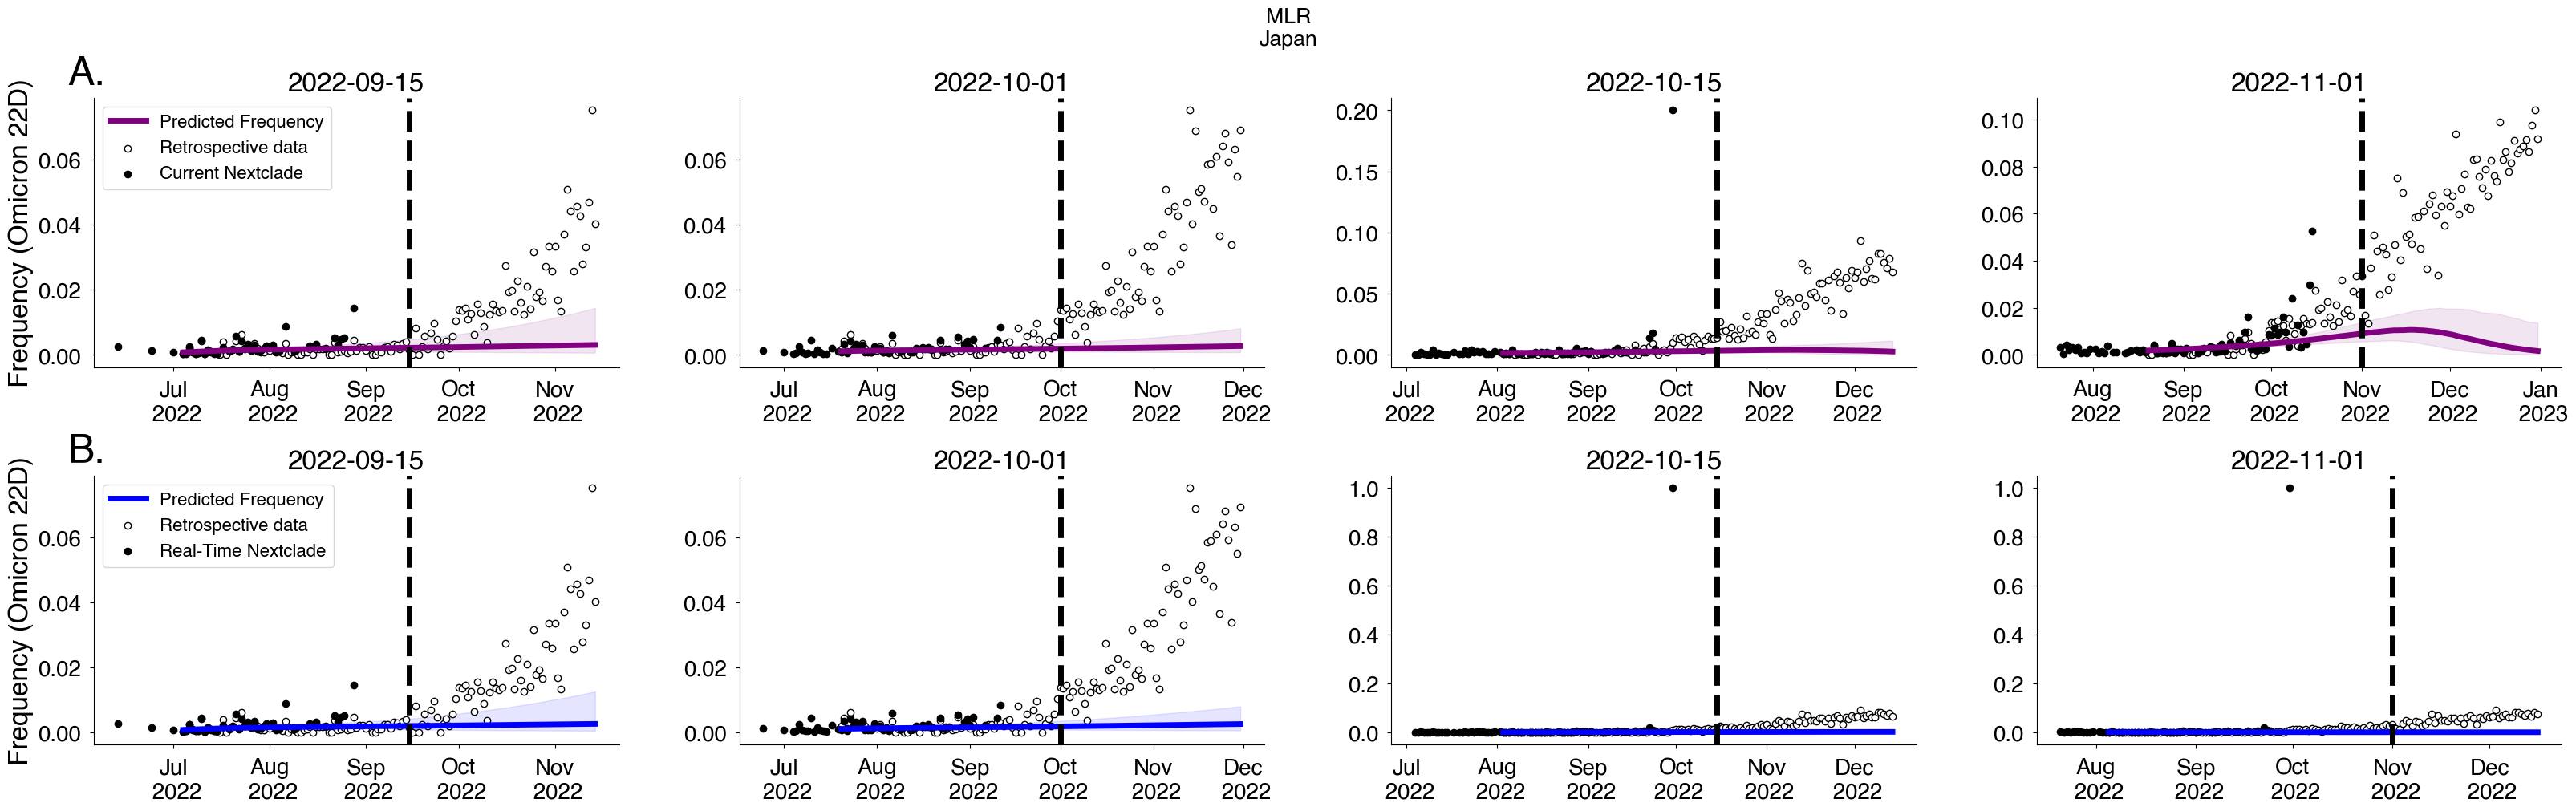

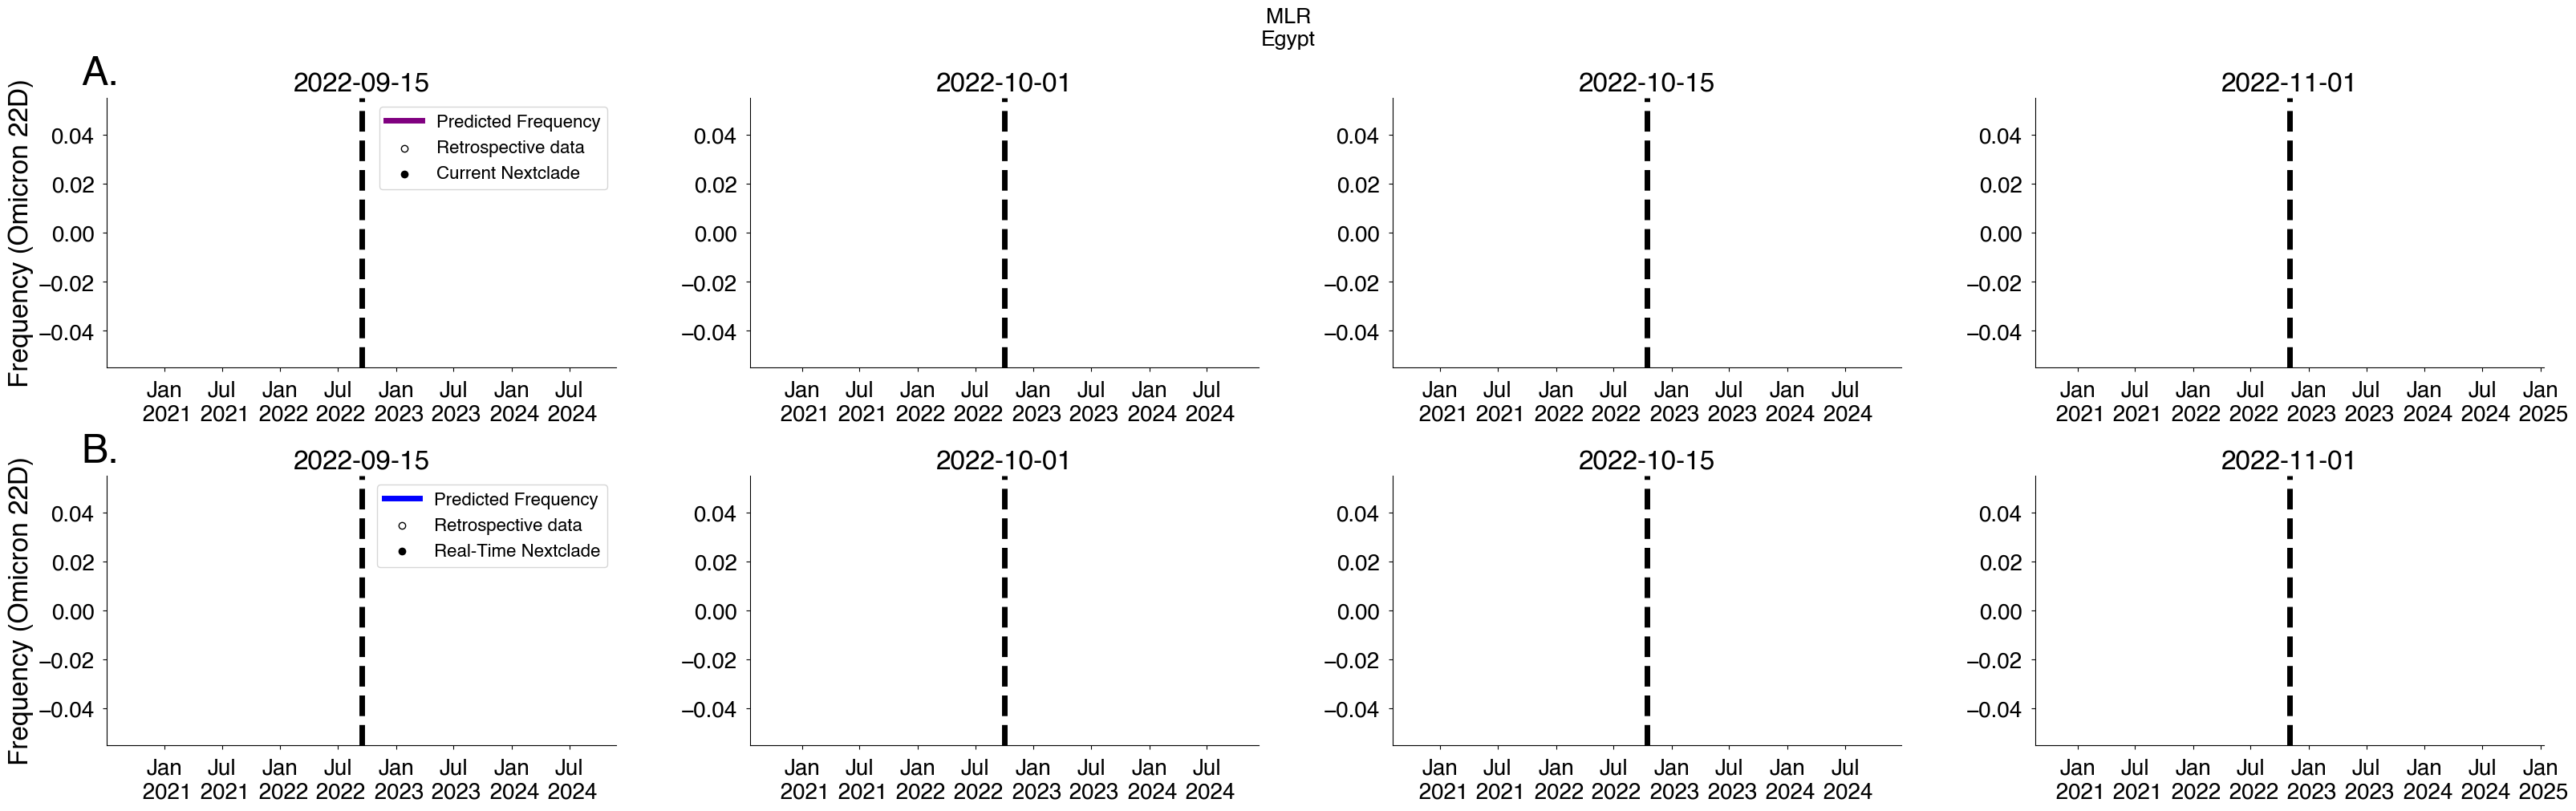

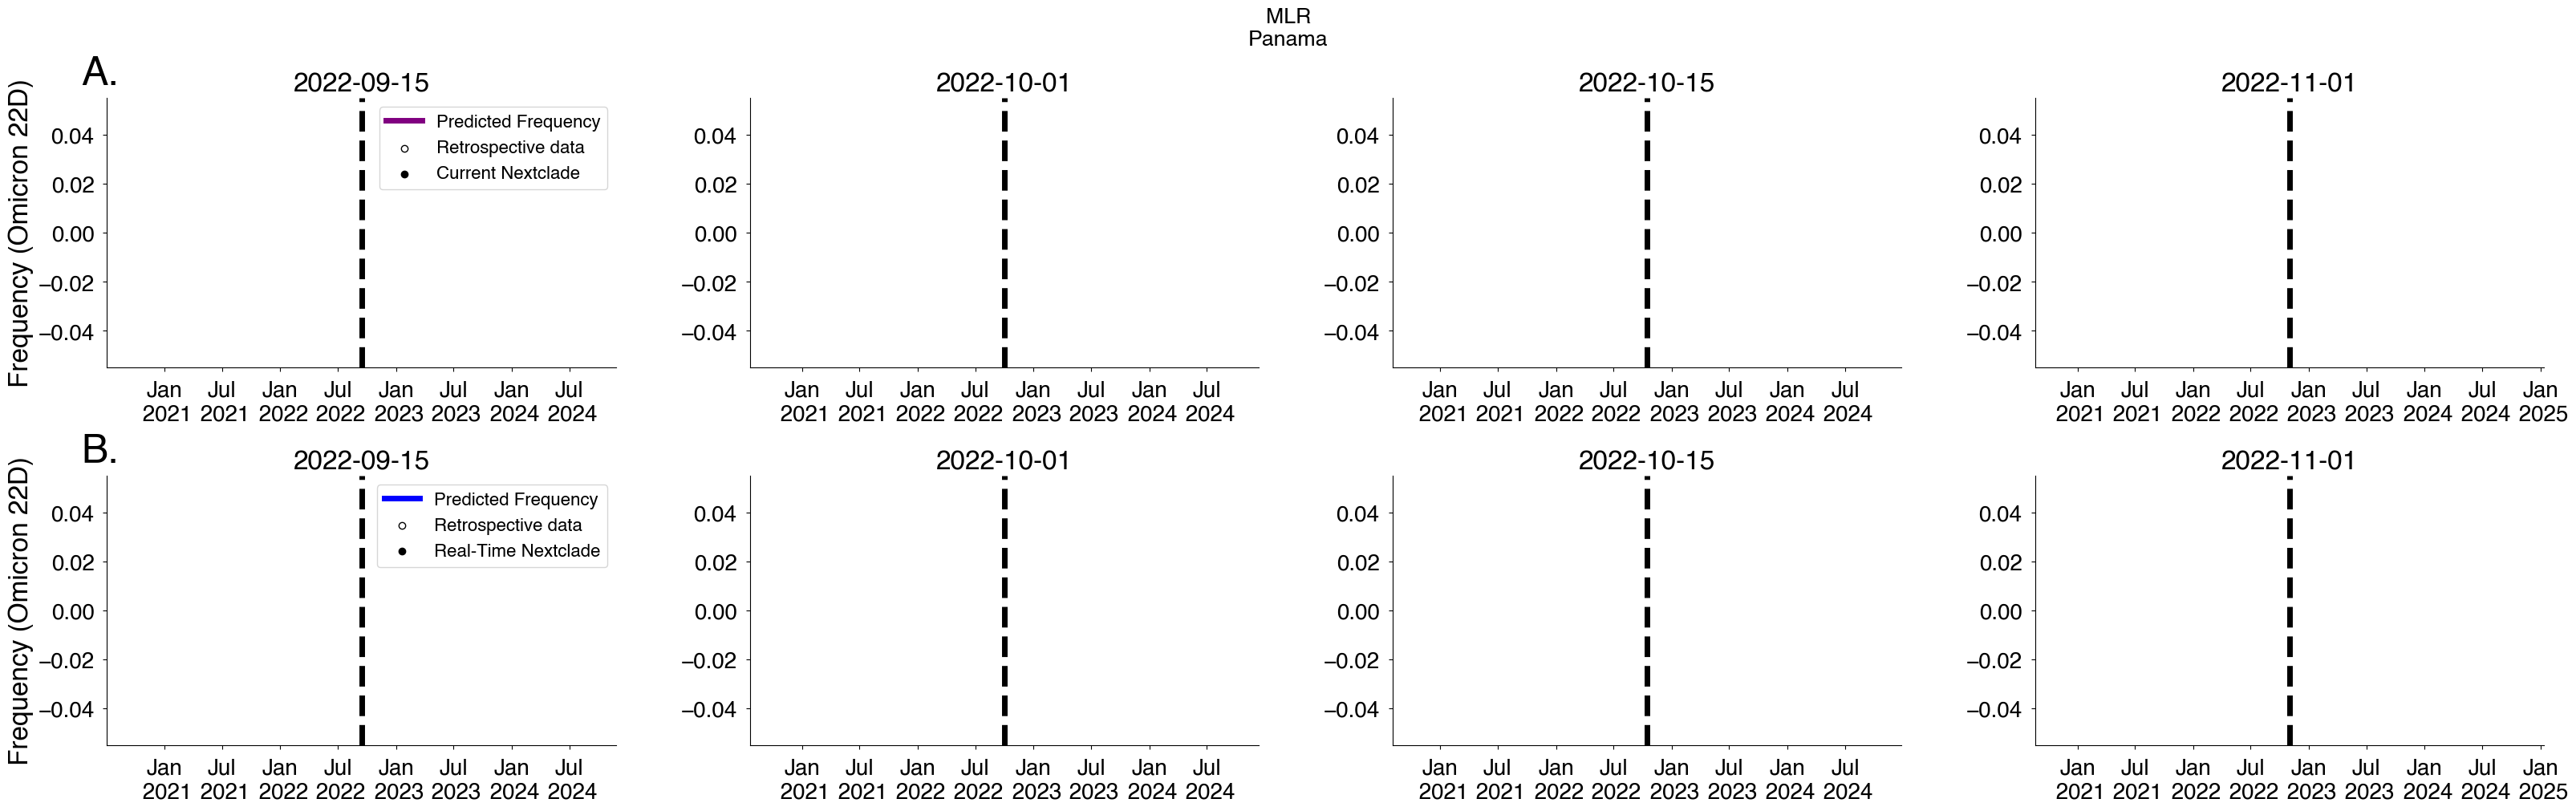

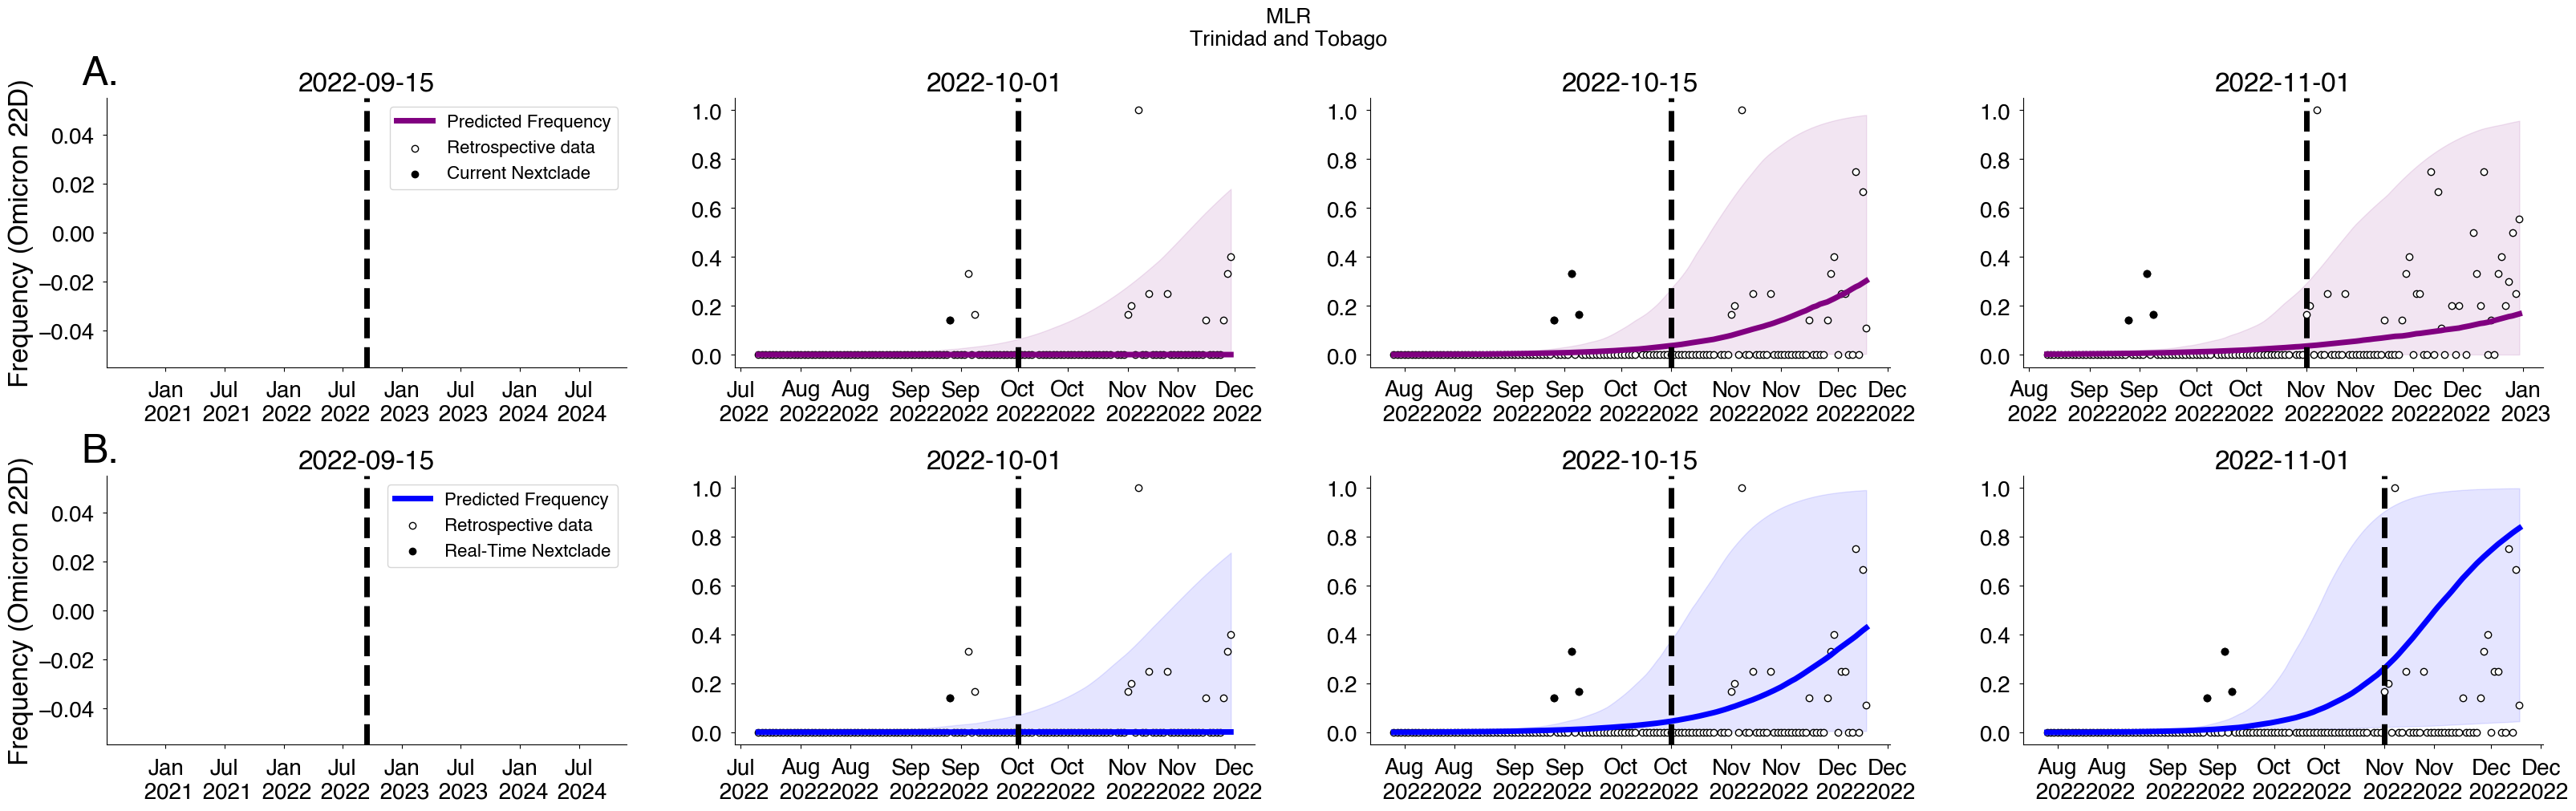

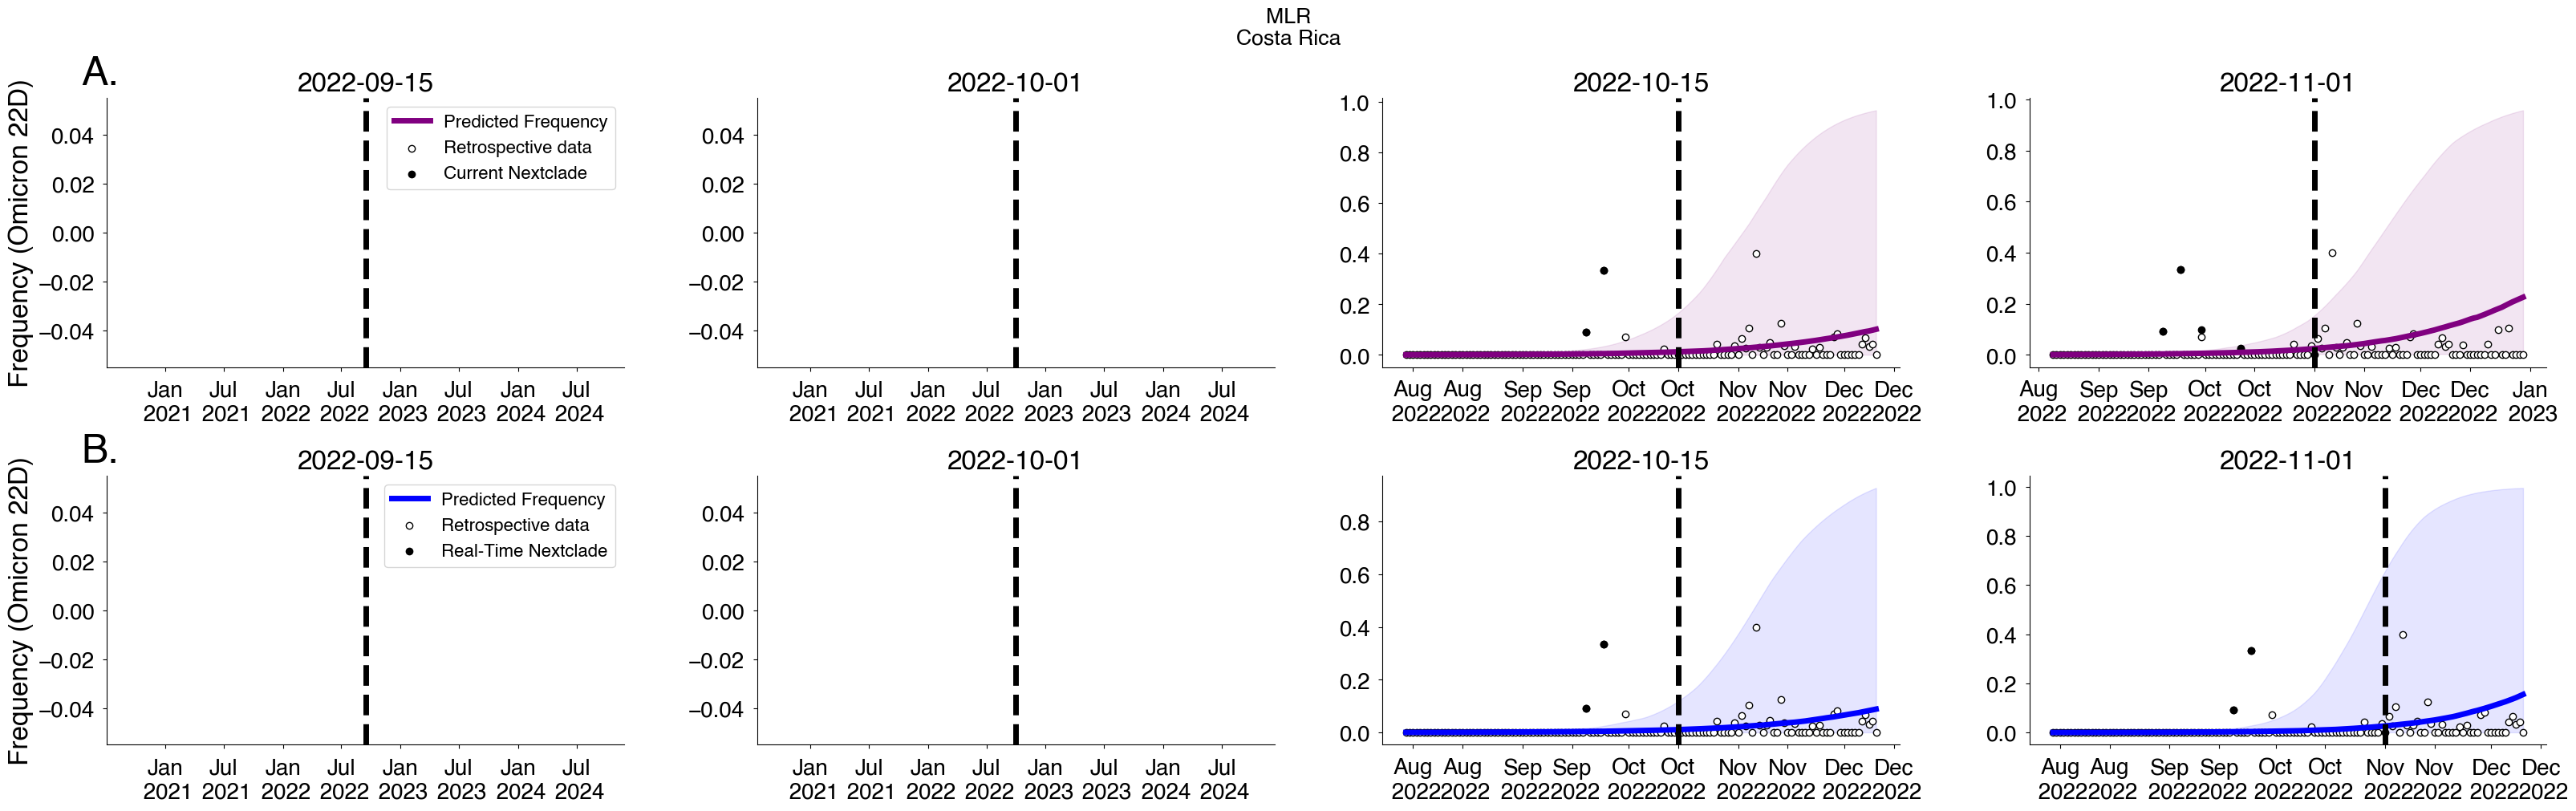

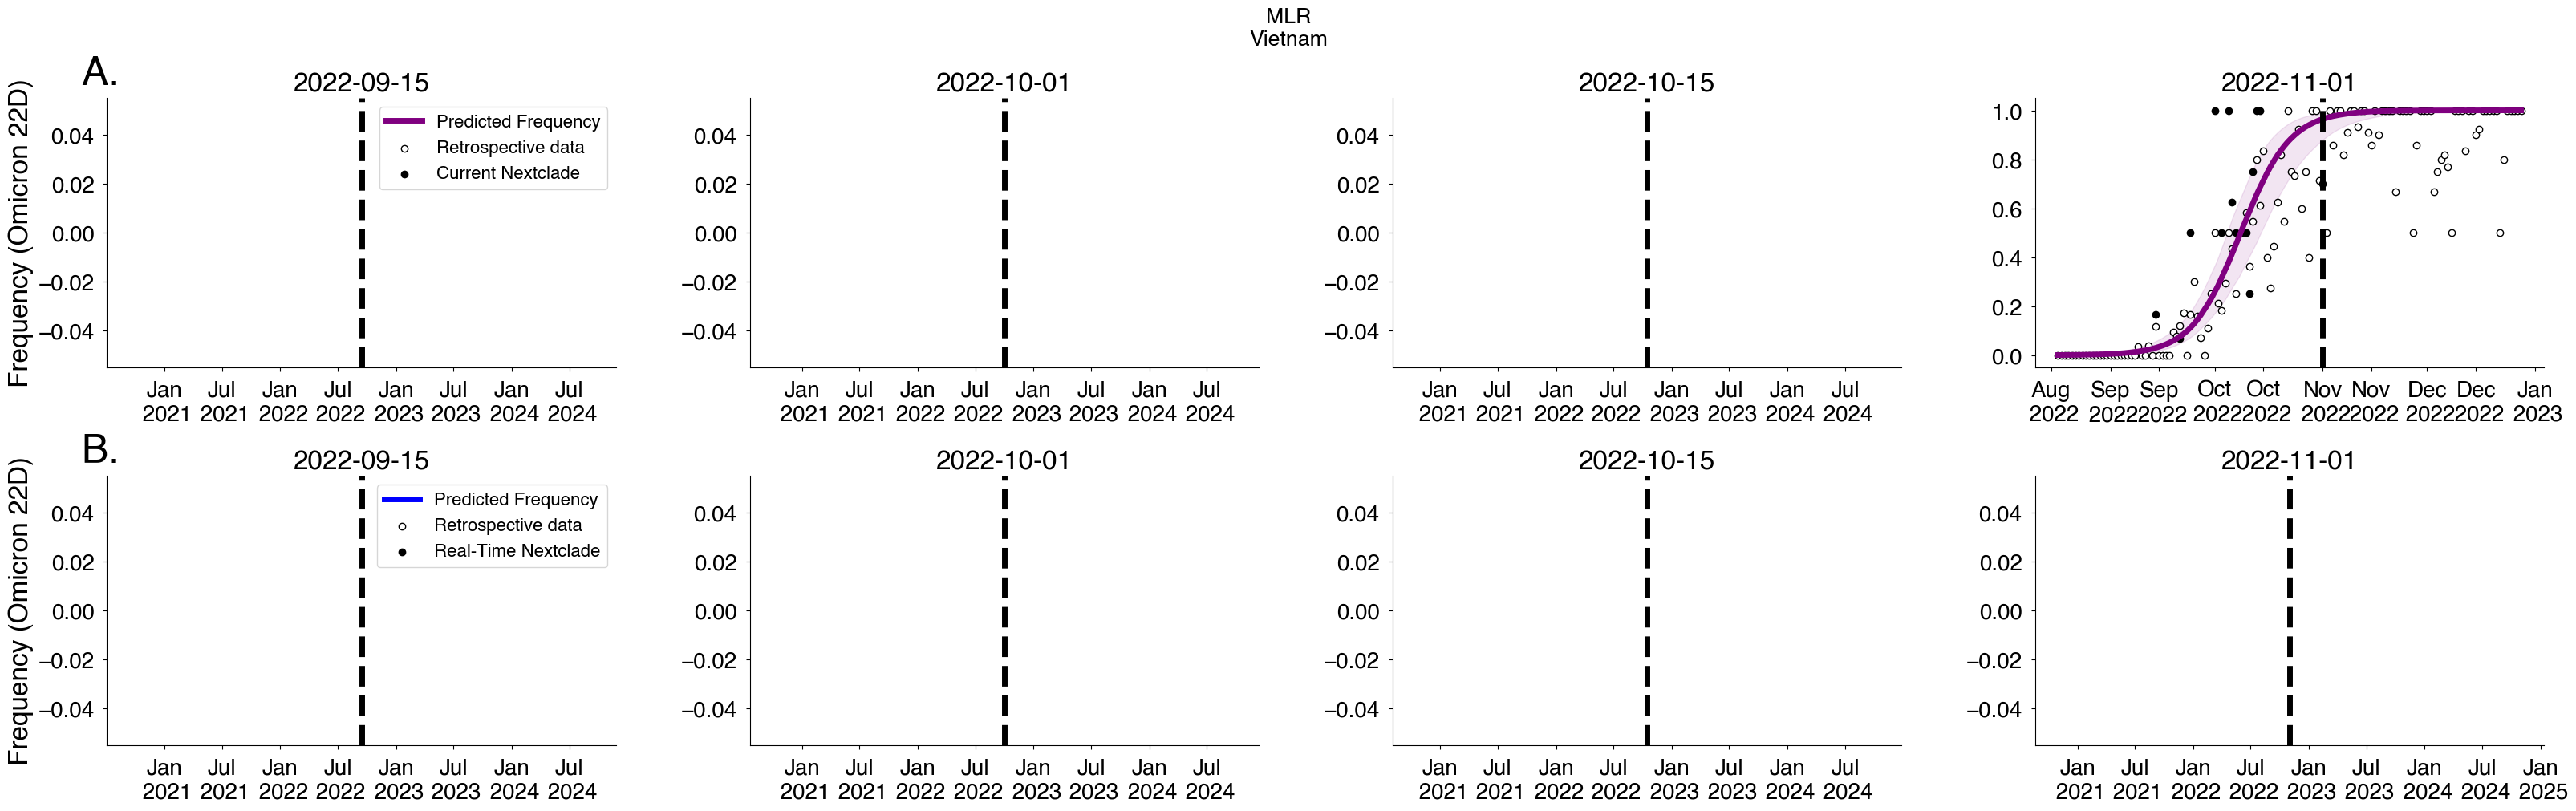

In [15]:
plots_loc = {}
for location in errors.location.unique():
    plots_loc[location] = make_nextclade_comparison_plot(variant, location, model)

In [90]:
mean_mae = (errors
    .groupby(["location", "nextclade_version", "lead"])
    .agg({'MAE':['mean','sem']})
    .reset_index()
)

mean_mae.columns = ['location', 'nextclade_version', 'lead', 'MAE_mean', 'MAE_sem']
mean_mae

location nextclade_version  lead  MAE_mean   MAE_sem
0     Australia         real_time   -84  0.005922  0.002108
1     Australia         real_time   -83  0.004443  0.001201
2     Australia         real_time   -82  0.003557  0.000848
3     Australia         real_time   -81  0.003159  0.000636
4     Australia         real_time   -80  0.003434  0.001108
...         ...               ...   ...       ...       ...
3289    Vietnam     retrospective    56  0.150707  0.047480
3290    Vietnam     retrospective    57  0.150105  0.047906
3291    Vietnam     retrospective    58  0.170874  0.055292
3292    Vietnam     retrospective    59  0.171184  0.055278
3293    Vietnam     retrospective    60  0.171253  0.054706

[3294 rows x 5 columns]

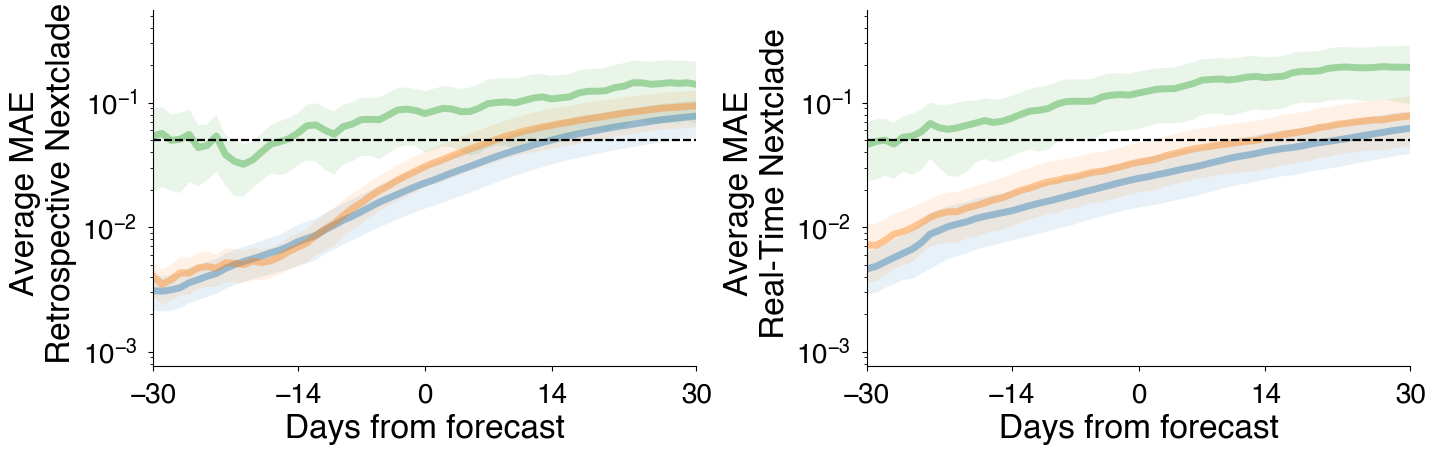

In [128]:
# Plot MAE over lead for each data set
fig = plt.figure(figsize=(36., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=6, nrows=2)

def plot_error_by_version(ax, mean_mae, nextclade_version, location, ylabel=None, desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    _mean_mae = _mean_mae[_mean_mae.nextclade_version == nextclade_version]

    _mean_mae = _mean_mae[_mean_mae.location == location]

    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4)
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)

for n, nextclade_version in enumerate(["retrospective", "real_time"]):
    ax = fig.add_subplot(spec[n])
    
    if n == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    for loc in ["USA", "United Kingdom", "Vietnam"]:
        plot_error_by_version(ax, mean_mae, nextclade_version, location=loc, ylabel=f"Average MAE \n {NC_VERSION_TO_LABEL[nextclade_version]}")

    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    ax.set_yscale("log", base=10)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_3997/3295675752.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


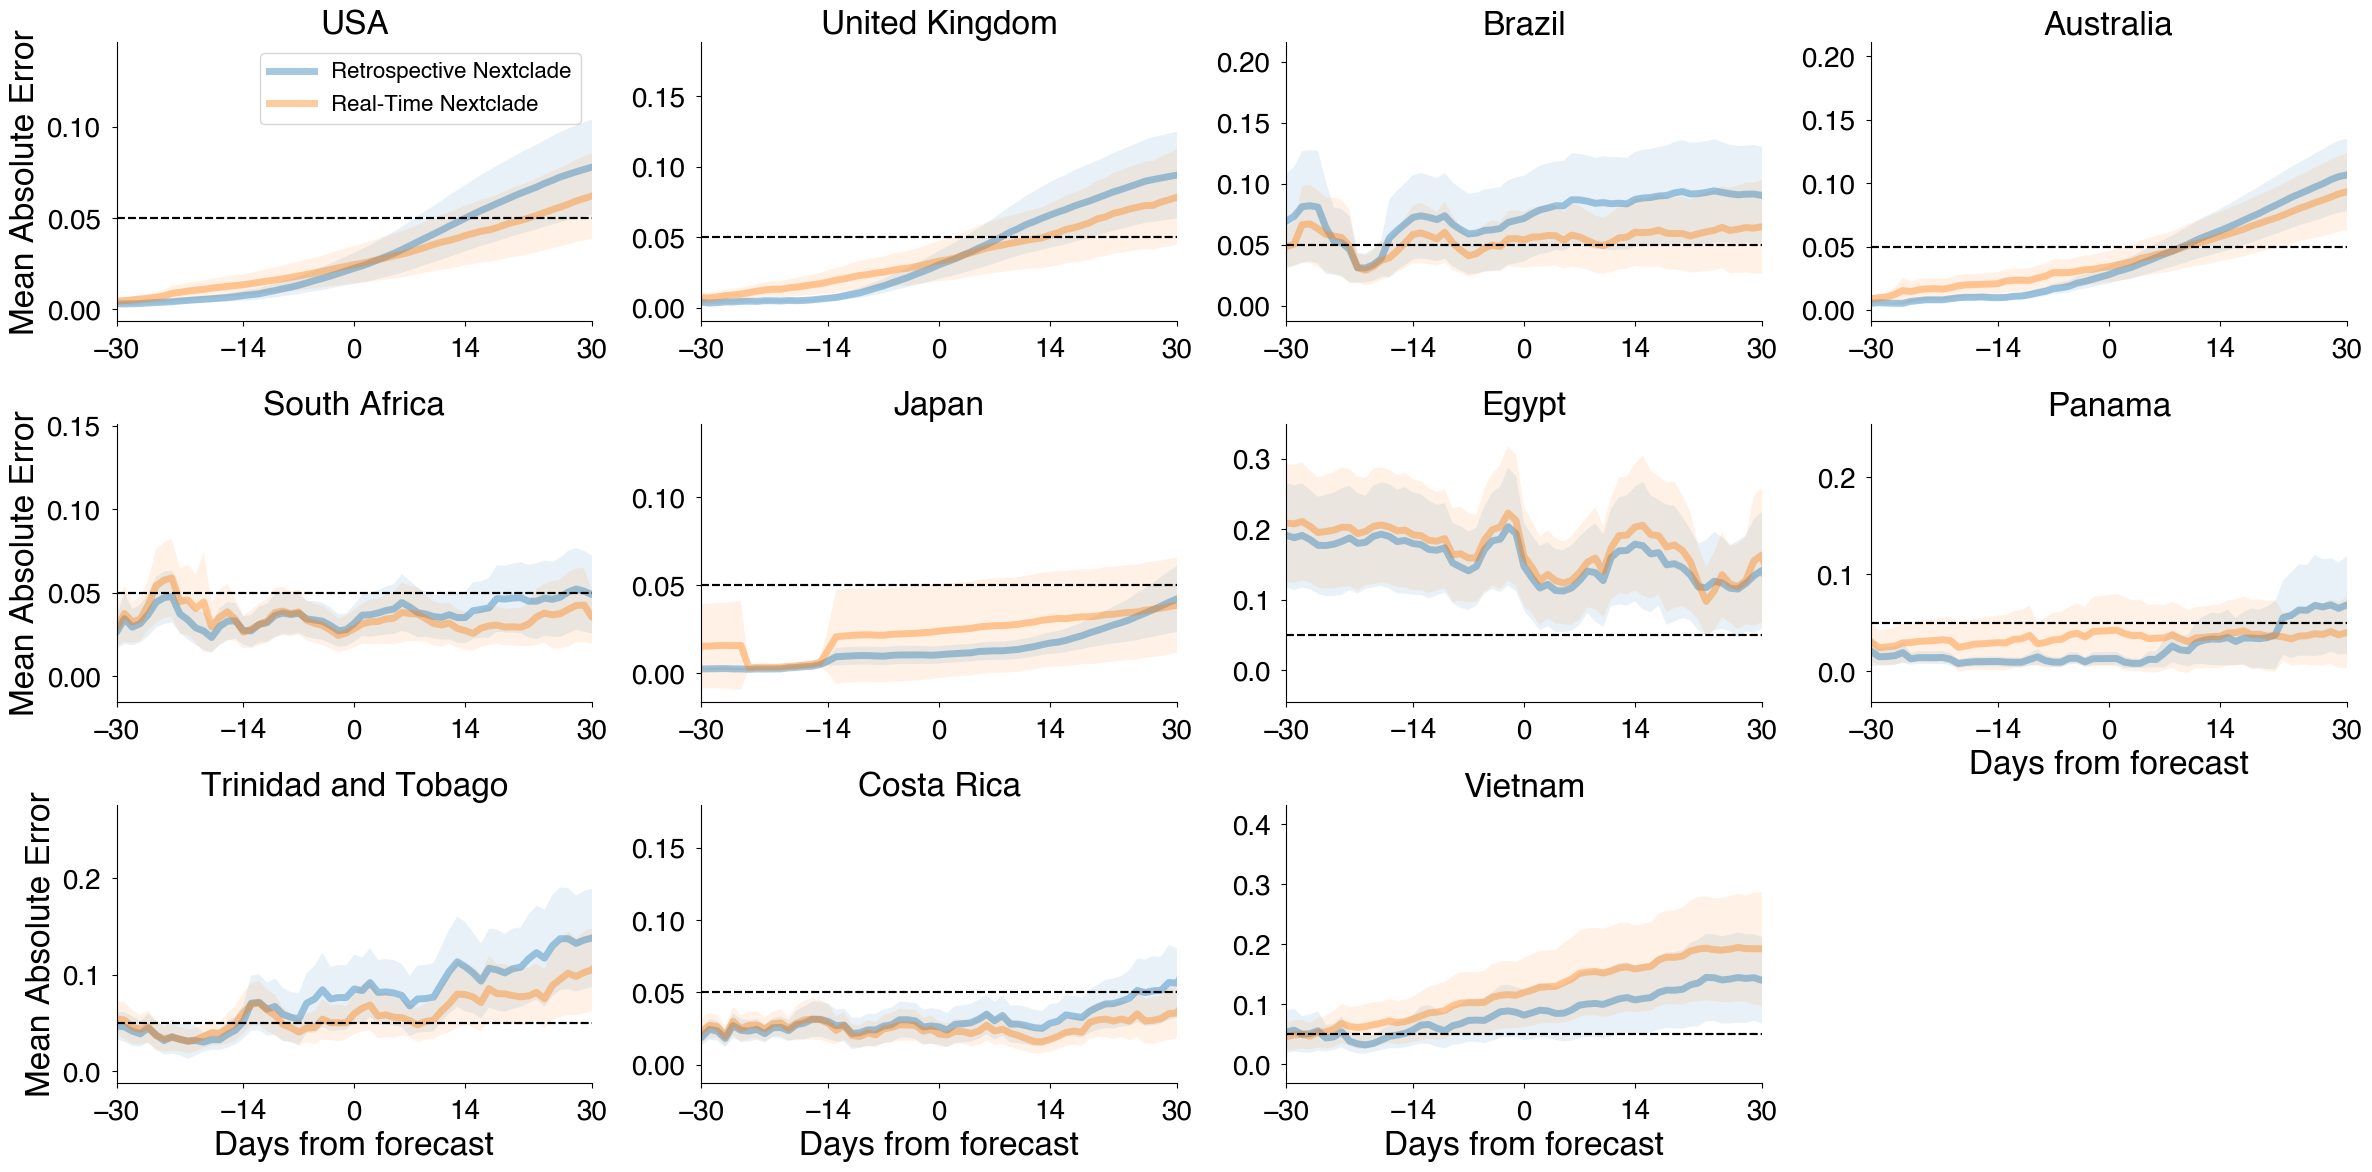

In [142]:
# Really want to compare for each country

# Plot MAE over lead for each data set
fig = plt.figure(figsize=(24., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=4, nrows=3)

def plot_error_by_version(ax, mean_mae, nextclade_version, location, ylabel=None, xlabel="Days from forecast", desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    _mean_mae = _mean_mae[_mean_mae.nextclade_version == nextclade_version]

    _mean_mae = _mean_mae[_mean_mae.location == location]

    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4, label=NC_VERSION_TO_LABEL[nextclade_version])
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)

for l, loc in enumerate(errors.location.unique()):
    ax = fig.add_subplot(spec[l])

    for nextclade_version in ["retrospective", "real_time"]:
        ylabel = "Mean Absolute Error" if l % 4 == 0 else ""
        xlabel = "Days from forecast" if l > 6 else ""
        plot_error_by_version(ax, mean_mae, nextclade_version, location=loc, ylabel=ylabel,xlabel=xlabel)

    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    
    #ax.set_yscale("log", base=10)
    ax.set_title(loc)
    if l == 0:
        ax.legend()
fig.tight_layout()

# Filter to ones, we actually use: T&T & VN, Drop Costa Rica, Panama, Egypt